<a href="https://colab.research.google.com/github/himanshuSri24/text-generation-model-from-regional-sign-language/blob/main/Copy_of_DL_Model_SIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing and importing modules and libraries

In [ ]:
!pip install tensorflow opencv-python mediapipe sklearn matplotlib

In [ ]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [ ]:
# !pip install moviepy
from moviepy.editor import VideoFileClip

Creating Mediapipe holistic models for holistic keypoint extraction

In [ ]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

Processing frames to extract holistic keypoints

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

Drawing the keypoints of detection on the individual frames to show the user

In [ ]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

Styling the keypoints shown in real time (thus, previous function was just for basic one, not using that)

In [ ]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

Importing one video, extracting frames and keypoints and checking if code is working before applying it for all videos (Basically, preprocessing)

In [ ]:
import cv2
import mediapipe as mp
import os

folder_path = r"E:\Downloads\Datasets\Sorted dataset\DATASET\happy\0"
video_path = r"E:\Downloads\Datasets\Sorted dataset\DATASET\happy\0\0.mov"

# Open the video using OpenCV
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")

frame_rate = 20  # Desired frame rate (in fps)
delay = int(1000 / frame_rate)  # Delay between frames (in milliseconds)

last_frame, last_result = None, None
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()

        # Check if the frame is empty
        if not ret:
            break
        # Crop the frame to keep only the middle 50% horizontally
        height, width, _ = frame.shape

        last_frame = frame
        # Make detections on the cropped frame
        image, results = mediapipe_detection(frame, holistic)
        last_result = results
        # Draw landmarks on the original frame
        draw_styled_landmarks(frame, results)

        # Show the original frame with landmarks to the screen
        cv2.imshow('OpenCV Feed', frame)

        # Delay between frames to achieve desired frame rate
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()


In [ ]:
draw_landmarks(last_frame, last_result)

As you can see, displaying keypoints on a frame

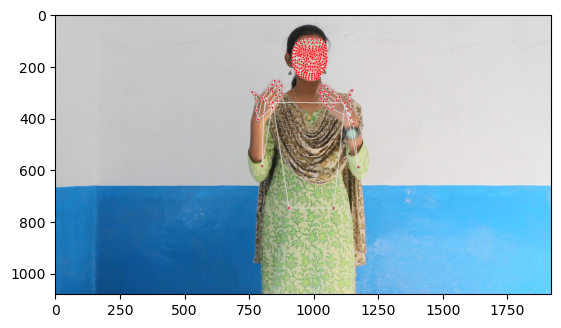

In [ ]:
plt.imshow(cv2.cvtColor(last_frame, cv2.COLOR_BGR2RGB))

Ignore from here

In [ ]:
len(results.left_hand_landmarks.landmark)

21

In [ ]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [ ]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
# face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [ ]:
# face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
# face

array([ 0.52184021,  0.1777826 , -0.02070025, ...,  0.57422024,
        0.13075264,  0.01291784])

Extracting keypoint coordinates and storing in 1d array so can be passed to CNN

In [ ]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [ ]:
result_test = extract_keypoints(results)

In [ ]:
result_test

array([ 5.21123827e-01,  1.76591501e-01, -3.91891211e-01,  9.99498188e-01,
        5.27858078e-01,  1.46530569e-01, -3.70373726e-01,  9.99475896e-01,
        5.32821298e-01,  1.46525979e-01, -3.70527208e-01,  9.99478161e-01,
        5.37078857e-01,  1.46274075e-01, -3.70717108e-01,  9.99431670e-01,
        5.09335160e-01,  1.48379996e-01, -3.68192196e-01,  9.99140978e-01,
        5.02125978e-01,  1.49285346e-01, -3.68303865e-01,  9.99008119e-01,
        4.95056152e-01,  1.50169581e-01, -3.68388861e-01,  9.98870850e-01,
        5.42386711e-01,  1.59544408e-01, -1.96171075e-01,  9.99463618e-01,
        4.84591752e-01,  1.65135905e-01, -1.91600651e-01,  9.98677731e-01,
        5.30381382e-01,  2.07226232e-01, -3.23341221e-01,  9.99611557e-01,
        5.07294059e-01,  2.08396927e-01, -3.21988136e-01,  9.99438345e-01,
        5.84752202e-01,  3.17164451e-01, -8.45339298e-02,  9.99639928e-01,
        4.39360172e-01,  3.16427231e-01, -3.62059735e-02,  9.98309851e-01,
        6.11483157e-01,  

In [ ]:
np.save(folder_path+'/0', result_test)

In [ ]:
np.load(folder_path+'/0.npy')

array([ 0.51683658,  0.15698361, -0.90428203, ...,  0.34478003,
        0.88616538,  0.01155938])

Setting number of videos in each folder and number of frames in them

In [ ]:
import os
import numpy as np

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('E:\\Downloads\\Datasets\\DATASET1\\DATASET\\')
print(DATA_PATH)

# DATA_PATH1 = os.path.join('E:\\Downloads\\Datasets\\DATASET1\\test\\')
# print(DATA_PATH1)


# Actions that we try to detect
actions = np.array(['good morning',
 'big',
 'you',
 'alright',
 'thank you',
 'time',
 'hello',
 'plane',
 'happy',
 'good',
 'good night',
 'short',
 'me',
 'bicycle',
 'tall',
'young',
'slow',
'new',
'Sick',
'cool'])

print(actions)

# actions = np.array(['young', 'slow', 'new', 'Sick', 'cool'])

# Thirty videos worth of data
no_sequences = 20

# Videos are going to be 40 frames in length
sequence_length = 40

# Folder start
start_folder = 0

E:\Downloads\Datasets\DATASET1\DATASET\
['good morning' 'big' 'you' 'alright' 'thank you' 'time' 'hello' 'plane'
 'happy' 'good' 'good night' 'short' 'me' 'bicycle' 'tall' 'young' 'slow'
 'new' 'Sick' 'cool']


In [ ]:
paths = []
for path in os.listdir('E:\Downloads\Datasets\DATASET\\'):
  paths.append(path)
paths

['good morning']

Creating folder structure


In [ ]:
for action in actions:
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(1,no_sequences+1):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
        except:
            pass

In [ ]:
cap.release()

Extracting keypoint values from frames and saving the numpy array as files locally

In [ ]:
# Getting the np values

# cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        numVids = len(os.listdir(DATA_PATH+action+'\\'))
        print("Action : ", DATA_PATH+action)
        for sequence in range(start_folder, numVids):
            # Loop through video length aka sequence length
            video_path = DATA_PATH+action+'\\'+str(sequence)+'\\'+str(sequence)+'.mov'
            print("Video: ", video_path.split('\\')[-1])
            # print(video_path)
            cap = cv2.VideoCapture(video_path)
            # print("Length : ", length)
            for frame_num in range(sequence_length):
                # pass
                # Read feed
                ret, frame = cap.read()

                if not ret:
                  print("Frame num : ", frame_num, " Is the last frame.")
                  break
                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)

                # NEW Apply wait logic
                # if frame_num == 0:
                    # cv2.putText(image, 'STARTING COLLECTION', (120,200),
                              #  cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    # cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                              #  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    # cv2.imshow('OpenCV Feed', image)
                    # cv2.waitKey(500)
                # else:
                    # cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12),
                              #  cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    # cv2.imshow('OpenCV Feed', image)

                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

In [ ]:
import numpy as np

# Set the desired number of frames per video
desired_frames = 40

# cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:

    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        numVids = len(os.listdir(DATA_PATH+action+'\\'))
        print("Action : ", DATA_PATH+action)
        for sequence in range(start_folder, numVids):

            # Loop through video length aka sequence length
            video_path = DATA_PATH+action+'\\'+str(sequence)+'\\'+str(sequence)+'.mov'
            print("Video: ", video_path.split('\\')[-1])
            cap = cv2.VideoCapture(video_path)
            # Store the frames in a list
            frames = []
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                if not ret:
                  print("Frame num : ", frame_num, " Is the last frame.")
                  break
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                # Draw landmarks
                draw_styled_landmarks(image, results)
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                frames.append(keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            # If the number of frames is greater than desired_frames, select the most evenly distributed frames
            if len(frames) > desired_frames:
                # Calculate the step size to evenly distribute the frames
                step_size = len(frames) / desired_frames
                # Select the frames based on the step size
                selected_frames = []
                for i in range(desired_frames):
                    frame_index = int(i * step_size)
                    selected_frames.append(frames[frame_index])
                frames = selected_frames
            # Save the selected frames as npy files
            for frame_num, keypoints in enumerate(frames):
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

# Loop through video length aka sequence length
            video_path = DATA_PATH+action+'\\'+str(sequence)+'\\'+str(sequence)+'lm.mov'
            create_path = os.path.join(DATA_PATH, action, str(sequence)+'l')
            os.makedirs(create_path)
            print("Video: ", video_path.split('\\')[-1])
            cap = cv2.VideoCapture(video_path)
            # Store the frames in a list
            frames = []
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                if not ret:
                  print("Frame num : ", frame_num, " Is the last frame.")
                  break
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                # Draw landmarks
                draw_styled_landmarks(image, results)
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                frames.append(keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            # If the number of frames is greater than desired_frames, select the most evenly distributed frames
            if len(frames) > desired_frames:
                # Calculate the step size to evenly distribute the frames
                step_size = len(frames) / desired_frames
                # Select the frames based on the step size
                selected_frames = []
                for i in range(desired_frames):
                    frame_index = int(i * step_size)
                    selected_frames.append(frames[frame_index])
                frames = selected_frames
            # Save the selected frames as npy files
            for frame_num, keypoints in enumerate(frames):
                npy_path = os.path.join(DATA_PATH, action, str(sequence)+'l', str(frame_num))
                np.save(npy_path, keypoints)


# Loop through video length aka sequence length
            video_path = DATA_PATH+action+'\\'+str(sequence)+'\\'+str(sequence)+'rm.mov'
            create_path = os.path.join(DATA_PATH, action, str(sequence)+'r')
            os.makedirs(create_path)
            print("Video: ", video_path.split('\\')[-1])
            cap = cv2.VideoCapture(video_path)
            # Store the frames in a list
            frames = []
            for frame_num in range(sequence_length):
                # Read feed
                ret, frame = cap.read()
                if not ret:
                  print("Frame num : ", frame_num, " Is the last frame.")
                  break
                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                # Draw landmarks
                draw_styled_landmarks(image, results)
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                frames.append(keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

            # If the number of frames is greater than desired_frames, select the most evenly distributed frames
            if len(frames) > desired_frames:
                # Calculate the step size to evenly distribute the frames
                step_size = len(frames) / desired_frames
                # Select the frames based on the step size
                selected_frames = []
                for i in range(desired_frames):
                    frame_index = int(i * step_size)
                    selected_frames.append(frames[frame_index])
                frames = selected_frames
            # Save the selected frames as npy files
            for frame_num, keypoints in enumerate(frames):
                npy_path = os.path.join(DATA_PATH, action, str(sequence)+'r', str(frame_num))
                np.save(npy_path, keypoints)



    cap.release()
    cv2.destroyAllWindows()


Action :  E:\Downloads\Datasets\DATASET1\test\young
Video:  0.mov
Video:  0lm.mov
Video:  0rm.mov
Video:  1.mov
Video:  1lm.mov
Video:  1rm.mov
Video:  2.mov
Video:  2lm.mov
Video:  2rm.mov
Video:  3.mov
Video:  3lm.mov
Video:  3rm.mov
Video:  4.mov
Video:  4lm.mov
Video:  4rm.mov
Video:  5.mov
Video:  5lm.mov
Video:  5rm.mov
Video:  6.mov
Video:  6lm.mov
Video:  6rm.mov
Video:  7.mov
Video:  7lm.mov
Video:  7rm.mov
Video:  8.mov
Video:  8lm.mov
Video:  8rm.mov
Video:  9.mov
Video:  9lm.mov
Video:  9rm.mov
Video:  10.mov
Video:  10lm.mov
Video:  10rm.mov
Video:  11.mov
Video:  11lm.mov
Video:  11rm.mov
Video:  12.mov
Video:  12lm.mov
Video:  12rm.mov
Video:  13.mov
Video:  13lm.mov
Video:  13rm.mov
Video:  14.mov
Video:  14lm.mov
Video:  14rm.mov
Video:  15.mov
Video:  15lm.mov
Video:  15rm.mov
Video:  16.mov
Video:  16lm.mov
Video:  16rm.mov
Video:  17.mov
Video:  17lm.mov
Video:  17rm.mov
Video:  18.mov
Video:  18lm.mov
Video:  18rm.mov
Video:  19.mov
Video:  19lm.mov
Video:  19rm.mo

In [ ]:
# # File operations

# import os
# import shutil

# # Path to the 'outer' folder
# outer_folder = DATA_PATH+'big'
# print(outer_folder)

# subfolders = [f.path for f in os.scandir(outer_folder) if f.is_dir()]

# for subfolder in subfolders:
#     mov_files = [f for f in os.listdir(subfolder) if f.endswith('.mov')]

#     # Move each .mov file to the 'outer' folder
#     for mov_file in mov_files:
#         src_path = os.path.join(subfolder, mov_file)
#         dst_path = os.path.join(outer_folder, mov_file)
#         shutil.move(src_path, dst_path)



Renaming files

In [ ]:
# # File operations

# folderNames = ['good morning',
#  'big',
#  'you',
#  'alright',
#  'thank you',
#  'car',
#  'time',
#  'hello',
#  'plane',
#  'happy',
#  'good',
#  'good night',
#  'short',
#  'me',
#  'bicycle',
#  'tall']
# # for name in folderNames:
# outer_folder = r"E:\Downloads\Datasets\DATASET1\DATASET" + '\\' + 'tall'

# mov_files = [f for f in os.listdir(outer_folder)]

# # Sort the list of .mov files
# mov_files.sort()

# # Rename the .mov files
# for i, mov_file in enumerate(mov_files):
#     src_path = os.path.join(outer_folder, mov_file)
#     dst_path = os.path.join(outer_folder, f"{i}")
#     os.rename(src_path, dst_path)

Label creation

In [ ]:
# preprocess and create labels and features

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
label_map = {label: num for num, label in enumerate(actions)}
label_map

{'good morning': 0,
 'big': 1,
 'you': 2,
 'alright': 3,
 'thank you': 4,
 'time': 5,
 'hello': 6,
 'plane': 7,
 'happy': 8,
 'good': 9,
 'good night': 10,
 'short': 11,
 'me': 12,
 'bicycle': 13,
 'tall': 14,
 'young': 15,
 'slow': 16,
 'new': 17,
 'Sick': 18,
 'cool': 19}

Flattening arrays to pass to CNN LSTM


In [ ]:
sequences, labels = [], []
for action in actions:
    try:
      print("Action : ", action)
      for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))):
          window = []
          if len(os.listdir(os.path.join(DATA_PATH, action, sequence))) < 40:
            print("Less frames")
            continue
          for frame_num in range(sequence_length):
                res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
                window.append(res)
          sequences.append(window)
          labels.append(label_map[action])

          window = []
          for frame_num in range(sequence_length):

                res = np.load(os.path.join(DATA_PATH, action, str(sequence)+'l', "{}.npy".format(frame_num)))
                window.append(res)
                print(os.path.join(DATA_PATH, action))
          sequences.append(window)
          labels.append(label_map[action])

          window = []
          for frame_num in range(sequence_length):

                res = np.load(os.path.join(DATA_PATH, action, str(sequence) + 'r', "{}.npy".format(frame_num)))
                window.append(res)
          sequences.append(window)
          labels.append(label_map[action])
    except Exception as e:
      print(e)
      continue

Streaming output truncated to the last 5000 lines.
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DATASET1\DATASET\me
E:\Downloads\Datasets\DAT

Checking count of numpy arrays

In [ ]:
# npy count
import os

folder_path = DATA_PATH + "plane"

# Initialize variables
min_count = float('inf')  # Set initial minimum count to infinity
max_count = 0  # Set initial maximum count to zero

# Iterate over the subfolders
for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)

    # Count the number of .npy files in the subfolder
    npy_count = len([file for file in os.listdir(subfolder_path) if file.endswith('.npy')])

    # Update minimum and maximum counts
    min_count = min(min_count, npy_count)
    max_count = max(max_count, npy_count)

# Print the minimum and maximum counts
print("Minimum number of .npy files in a folder:", min_count)
print("Maximum number of .npy files in a folder:", max_count)


Minimum number of .npy files in a folder: 40
Maximum number of .npy files in a folder: 40


In [ ]:
folderNames = ['good morning', 'big', 'you', 'alright', 'thank you', 'car', 'time', 'hello', 'plane', 'happy', 'good', 'good night', 'short', 'me', 'bicycle', 'tall']

print("Class:\t\tNumber of videos:\tNumber of frames per class:")
for folder in folderNames:
    print(f"{folder.ljust(12)}    60\t\t\t 2400")
print("Total number of frames: ", 2400*15)

Class:		Number of videos:	Number of frames per class:
good morning    60			 2400
big             60			 2400
you             60			 2400
alright         60			 2400
thank you       60			 2400
car             60			 2400
time            60			 2400
hello           60			 2400
plane           60			 2400
happy           60			 2400
good            60			 2400
good night      60			 2400
short           60			 2400
me              60			 2400
bicycle         60			 2400
tall            60			 2400
Total number of frames:  36000


In [ ]:
# # deleting npy files
# import os
# folderNames = ['good morning',
#  'big',
#  'you',
#  'alright',
#  'thank you',
#  'car',
#  'time',
#  'hello',
#  'plane',
#  'happy',
#  'good',
#  'good night',
#  'short',
#  'me',
#  'bicycle',
#  'tall']
# for name in folderNames:
#   folder_path = r"E:\Downloads\Datasets\DATASET1\DATASET" + '\\' + name

#   # Iterate over the subfolders
#   for subfolder in os.listdir(folder_path):
#       subfolder_path = os.path.join(folder_path, subfolder)
#       print(subfolder_path)

#       # Delete the .npy files in the subfolder
#       if(os.path.isdir(subfolder_path)):
#         for file in os.listdir(subfolder_path):
#             if file.endswith('.npy'):
#                 file_path = os.path.join(subfolder_path, file)
#                 os.remove(file_path)


In [ ]:
np.array(sequences).shape

(1087, 40, 258)

In [ ]:
np.array(labels).shape

(1087,)

In [ ]:
X = np.array(sequences)

In [ ]:
X.shape

(1087, 40, 258)

In [ ]:
y = to_categorical(labels).astype(int)
y.shape

(1087, 20)

From here on, splitting training and test data, then model creation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [ ]:
y_test.shape

(164, 20)

In [ ]:
# LSTM Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
log_dir = os.path.join(DATA_PATH, 'Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
print(log_dir)

E:\Downloads\Datasets\DATASET1\DATASET\Logs


In [ ]:
# !pip install tensorboard
%reload_ext tensorboard
%tensorboard --logdir log_dir

Reusing TensorBoard on port 6006 (pid 15584), started 2 days, 18:22:49 ago. (Use '!kill 15584' to kill it.)

LSTM model

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(40,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
del model
# model.save(DATA_PATH + '/models/modelWith16Classes.h5')

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=900, callbacks=[tb_callback])

Epoch 1/900
 9/24 [==========>...................] - ETA: 1s - loss: 2.6857 - categorical_accuracy: 0.0833

KeyboardInterrupt: ignored

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 40, 64)            82688     
                                                                 
 lstm_4 (LSTM)               (None, 40, 128)           98816     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 15)                495       
                                                                 
Total params: 237,647
Trainable params: 237,647
Non-tr

In [ ]:
del model

Deep learning model


In [ ]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(40, 258)))
model.add(BatchNormalization())
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(BatchNormalization())
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# class EarlyStopByAccuracy(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('accuracy') > 0.88:
#             print("\nReached 88% accuracy, stopping training...")
#             self.model.stop_training = True

# early_stop_callback = EarlyStopByAccuracy()

model.fit(X_train, y_train, epochs=1500, callbacks=[tb_callback])


Epoch 1/1500
29/29 [==============================] - 10s 107ms/step - loss: 2.7557 - accuracy: 0.1430
Epoch 2/1500
29/29 [==============================] - 3s 111ms/step - loss: 2.2019 - accuracy: 0.3142
Epoch 3/1500
29/29 [==============================] - 3s 108ms/step - loss: 1.6535 - accuracy: 0.5460
Epoch 4/1500
29/29 [==============================] - 3s 110ms/step - loss: 1.2174 - accuracy: 0.6685
Epoch 5/1500
29/29 [==============================] - 3s 111ms/step - loss: 0.8849 - accuracy: 0.7486
Epoch 6/1500
29/29 [==============================] - 3s 114ms/step - loss: 0.7791 - accuracy: 0.7757
Epoch 7/1500
29/29 [==============================] - 3s 113ms/step - loss: 0.6535 - accuracy: 0.8104
Epoch 8/1500
29/29 [==============================] - 3s 110ms/step - loss: 0.5707 - accuracy: 0.8234
Epoch 9/1500
29/29 [==============================] - 3s 110ms/step - loss: 0.6140 - accuracy: 0.8202
Epoch 10/1500
29/29 [==============================] - 3s 110ms/step - loss: 0.49

KeyboardInterrupt: ignored

In [ ]:

model.fit(X_train, y_train, epochs=1500, callbacks=[tb_callback])

Epoch 1/1500
29/29 [==============================] - 4s 113ms/step - loss: 0.0058 - accuracy: 0.9989
Epoch 2/1500
29/29 [==============================] - 3s 108ms/step - loss: 0.0108 - accuracy: 0.9967
Epoch 3/1500
29/29 [==============================] - 3s 107ms/step - loss: 0.0087 - accuracy: 0.9978
Epoch 4/1500
29/29 [==============================] - 3s 106ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 5/1500
29/29 [==============================] - 3s 109ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 6/1500
29/29 [==============================] - 3s 110ms/step - loss: 0.0117 - accuracy: 0.9967
Epoch 7/1500
29/29 [==============================] - 3s 110ms/step - loss: 0.0204 - accuracy: 0.9978
Epoch 8/1500
29/29 [==============================] - 3s 118ms/step - loss: 0.0119 - accuracy: 0.9957
Epoch 9/1500
29/29 [==============================] - 3s 111ms/step - loss: 0.0076 - accuracy: 0.9978
Epoch 10/1500
29/29 [==============================] - 3s 108ms/step - loss: 0.007

KeyboardInterrupt: ignored

In [ ]:
# D1M1:

print(model.summary())

# !pip install visualkeras
import visualkeras
visualkeras.layered_view(model)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 40, 64)            82688     
                                                                 
 batch_normalization (BatchN  (None, 40, 64)           256       
 ormalization)                                                   
                                                                 
 lstm_10 (LSTM)              (None, 40, 128)           98816     
                                                                 
 batch_normalization_1 (Batc  (None, 40, 128)          512       
 hNormalization)                                                 
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 batch_normalization_2 (Batc  (None, 64)              

TypeError: ignored

Model testing

In [ ]:
model.save(DATA_PATH + '/models/D2M1.h5')

In [ ]:
res = model.predict(X_test)

6/6 [==============================] - 0s 43ms/step


In [ ]:
print(res[0])

[1.5785485e-08 1.9167474e-12 1.2813860e-09 5.3637689e-07 3.3154853e-07
 1.5077388e-08 9.0707541e-13 9.9999726e-01 1.7087409e-10 3.9485379e-08
 3.1728040e-09 8.9831707e-09 3.0461352e-11 2.1353389e-07 1.2198473e-06
 1.9585855e-09 4.4939270e-07 3.2179433e-11 3.1194482e-08 1.2401835e-10]


In [ ]:
actions[np.argmax(res[0])], actions[np.argmax(res[1])], actions[np.argmax(res[2])], actions[np.argmax(res[3])]
# actions

('plane', 'young', 'good morning', 'tall')

In [ ]:
actions[np.argmax(y_test[0])], actions[np.argmax(y_test[1])], actions[np.argmax(y_test[2])], actions[np.argmax(y_test[3])]
# actions

('plane', 'young', 'good morning', 'tall')

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

6/6 [==============================] - 0s 38ms/step


In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# multilabel_confusion_matrix = np.array([[[36, 3], [0, 7]],
#                                         [[41, 1], [0, 4]],
#                                         [[42, 1], [1, 2]],
#                                         [[45, 0], [1, 0]],
#                                         [[43, 0], [3, 0]],
#                                         [[44, 1], [0, 1]],
#                                         [[43, 1], [0, 2]],
#                                         [[45, 0], [0, 1]],
#                                         [[44, 0], [2, 0]],
#                                         [[43, 0], [2, 1]],
#                                         [[41, 1], [0, 4]],
#                                         [[37, 3], [0, 6]],
#                                         [[41, 0], [3, 2]],
#                                         [[42, 1], [0, 3]],
#                                         [[45, 0], [0, 1]]])

# # Calculate the overall confusion matrix by summing up the 2x2 matrices
# confusion_matrix = np.sum(multilabel_confusion_matrix, axis=0)

# class_names = ['good morning', 'big', 'you', 'alright', 'thank you', 'car', 'time', 'hello', 'plane', 'happy', 'good', 'good night', 'short', 'me', 'bicycle', 'tall']

# num_classes = len(class_names)

# # Create a figure and axis
# fig, ax = plt.subplots()
# # Create a heatmap using the confusion matrix data
# im = ax.imshow(confusion_matrix, cmap='Blues')

# # Set the colorbar
# cbar = ax.figure.colorbar(im, ax=ax)

# # Set the axis labels
# ax.set_xticks(np.arange(num_classes))
# ax.set_yticks(np.arange(num_classes))
# ax.set_xticklabels(class_names, rotation=90)
# ax.set_yticklabels(class_names)

# # Loop over data dimensions and create text annotations for each cell
# for i in range(num_classes):
#     for j in range(num_classes):
#         text = ax.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='white' if confusion_matrix[i, j] > (np.max(confusion_matrix) / 2) else 'black')

# # Set the plot title
# ax.set_title("Confusion Matrix")

# # Show the plot
# plt.tight_layout()
# plt.show()


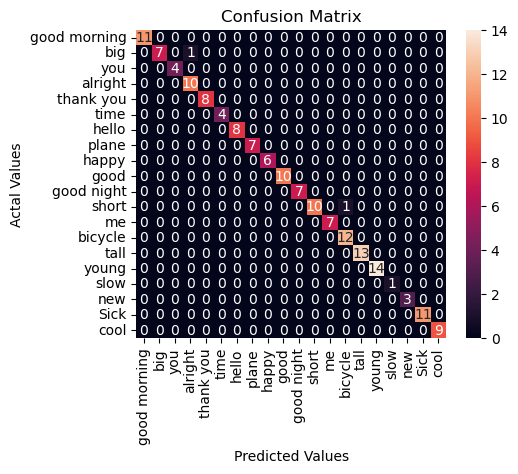

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import seaborn as sns

cf_matrix = multilabel_confusion_matrix(ytrue, yhat)
cm = confusion_matrix(ytrue, yhat)

cm_df = pd.DataFrame(cm,
                     index = ['good morning',
 'big',
 'you',
 'alright',
 'thank you',
 'time',
 'hello',
 'plane',
 'happy',
 'good',
 'good night',
 'short',
 'me',
 'bicycle',
 'tall',
'young',
'slow',
'new',
'Sick',
'cool'],
                     columns = ['good morning',
 'big',
 'you',
 'alright',
 'thank you',
 'time',
 'hello',
 'plane',
 'happy',
 'good',
 'good night',
 'short',
 'me',
 'bicycle',
 'tall',
'young',
'slow',
'new',
'Sick',
'cool'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
accuracy_score(ytrue, yhat)

0.9878048780487805

In [ ]:
from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(ytrue, yhat)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      0.88      0.93         8
           2       1.00      1.00      1.00         4
           3       0.91      1.00      0.95        10
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00         7
          11       1.00      0.91      0.95        11
          12       1.00      1.00      1.00         7
          13       0.92      1.00      0.96        12
          14       1.00      1.00      1.00        13
          15       1.00      1.00      1.00        14
          16       1.00      1.00      1.00         1
          17       1.00    

In [ ]:
# model.save()
# Load model
from tensorflow.keras.models import load_model

# Load the model
model = load_model(r"E:\Downloads\Datasets\DATASET1\DATASET\models\D2M1.h5")

# Now you can use the loaded model for real-time testing


Real time model implementation

In [ ]:
# Real time testing
from scipy import stats

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num%3], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    return output_frame

In [ ]:
!pip install mediapipe

In [ ]:
import keras
import tensorflow as tf

print("Keras version:", keras.__version__)
print("TensorFlow version:", tf.__version__)


Keras version: 2.12.0
TensorFlow version: 2.12.0


In [ ]:
from tensorflow.keras.models import load_model
model = load_model(r"E:\Downloads\Datasets\DATASET1\DATASET\models\D2M1.h5")

from scipy import stats

# colors = [(245,117,16), (117,245,16), (16,117,245)]
# def prob_viz(res, actions, input_frame, colors):
#     output_frame = input_frame.copy()
#     for num, prob in enumerate(res):
#         cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num%3], -1)
#         cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    # return output_frame

# Setup for test:

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from moviepy.editor import VideoFileClip

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

import os
import numpy as np

DATA_PATH = os.path.join('E:\\Downloads\\Datasets\\DATASET1\\DATASET\\')

# Actions that we try to detect
actions = np.array(['good morning',
 'big',
 'you',
 'alright',
 'thank you',
 'time',
 'hello',
 'plane',
 'happy',
 'good',
 'good night',
 'short',
 'me',
 'bicycle',
 'tall',
'young',
'slow',
'new',
'Sick',
'cool'])

no_sequences = 20
sequence_length = 40
start_folder = 0

# preprocess and create labels and features
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

label_map = {label: num for num, label in enumerate(actions)}


In [ ]:
!pip install tensorflowjs

UsageError: Line magic function `%tensorflowjs_converter` not found.


In [ ]:
# Modified by Himanshu

# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.9, min_tracking_confidence=0.9) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-40:]

        if len(sequence) == 40:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))

            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:

                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow('OpenCV Feed', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# Actual One

# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.9, min_tracking_confidence=0.9) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)

        # Draw landmarks
        # draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-40:]

        if len(sequence) == 40:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))


        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res):
                if res[np.argmax(res)] > threshold:

                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Viz probabilities
            # image = prob_viz(res, actions, image, colors)

        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30),
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model(r"C:\Users\aiish\Downloads\D2M1.h5")

# Define the function to process the webcam input
def recognize_sign_language(input_frame):
    # Perform the necessary preprocessing on the input frame
    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
    input_frame = cv2.flip(input_frame, 1)
    input_frame = cv2.resize(input_frame, (640, 480))  # Adjust the frame size as needed

    # Perform detection and prediction
    image, results = mediapipe_detection(input_frame, holistic)
    keypoints = extract_keypoints(results)
    sequence.append(keypoints)
    sequence = sequence[-40:]

    if len(sequence) == 40:
        res = model.predict(np.expand_dims(sequence, axis=0))[0]
        predictions.append(np.argmax(res))

    # Visualize the predictions on the frame
    cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
    cv2.putText(image, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Return the processed frame with the predictions
    return image

# Create a Gradio interface
webcam = gr.inputs.Video()  # No need to specify shape in this case
output = gr.outputs.Image(type="numpy")  # Specify the type as "numpy"

# Define the Gradio app with the webcam input and the output visualization
app = gr.Interface(fn=recognize_sign_language, inputs=webcam, outputs=output, capture_session=True)

# Launch the web application
app.launch()


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


In [ ]:
import gradio as gr
import cv2
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import load_model
from scipy import stats
from moviepy.editor import VideoFileClip

In [ ]:
model = load_model(r"C:\Users\aiish\Downloads\D2M1.h5")

In [ ]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results


In [ ]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])


In [ ]:
def predict_action(video):
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.5
    try:

      cap = cv2.VideoCapture(video)
      with mp_holistic.Holistic(min_detection_confidence=0.9, min_tracking_confidence=0.9) as holistic:
          while cap.isOpened():
              ret, frame = cap.read()
              frame = cv2.flip(frame, 1)
              image, results = mediapipe_detection(frame, holistic)
              keypoints = extract_keypoints(results)
              sequence.append(keypoints)
              sequence = sequence[-40:]

              if len(sequence) == 40:
                  res = model.predict(np.expand_dims(sequence, axis=0))[0]
                  predictions.append(np.argmax(res))

                  if np.unique(predictions[-10:])[0] == np.argmax(res):
                      if res[np.argmax(res)] > threshold:
                          if len(sentence) > 0:
                              if actions[np.argmax(res)] != sentence[-1]:
                                  sentence.append(actions[np.argmax(res)])
                          else:
                              sentence.append(actions[np.argmax(res)])

              if len(sentence) > 5:
                  sentence = sentence[-5:]

              cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
              cv2.putText(image, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

              cv2.imshow('OpenCV Feed', image)

              if cv2.waitKey(10) & 0xFF == ord('q'):
                  break
          cap.release()
          cv2.destroyAllWindows()
    except Exception as e:
      print(e)

      return sentence[-1]


In [ ]:
video_input = gr.inputs.Video(type='mp4')
label_output = gr.outputs.Label()

interface = gr.Interface(fn=predict_action, inputs=video_input, outputs=label_output)


In [ ]:
interface.launch()


Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


In [ ]:
from flask import Flask, render_template, request, Response
import cv2
import mediapipe as mp
import numpy as np

app = Flask(__name__)

def generate_frames():
    cap = cv2.VideoCapture(0)
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.5

    with mp_holistic.Holistic(min_detection_confidence=0.9, min_tracking_confidence=0.9) as holistic:
        while True:
            ret, frame = cap.read()
            frame = cv2.flip(frame, 1)
            image, results = mediapipe_detection(frame, holistic)

            # Process the frame, make predictions, and update the image
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-40:]

            if len(sequence) == 40:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))

                if np.unique(predictions[-10:])[0] == np.argmax(res):
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5:
                    sentence = sentence[-5:]

                cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
                cv2.putText(image, ' '.join(sentence), (3, 30),
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            ret, jpeg = cv2.imencode('.jpg', image)
            frame = jpeg.tobytes()
            yield (b'--frame\r\n'
                   b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n\r\n')

@app.route('/video_feed')
def video_feed():
    return Response(generate_frames(),
                    mimetype='multipart/x-mixed-replace; boundary=frame')

@app.route('/')
def index():
    return render_template('index.html')

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: ignored

In [ ]:
!pip install streamlit
!pip install opencv-python-headless
!pip install mediapipe
!pip install tensorflow
!pip install moviepy


     ---------------------------------------- 8.9/8.9 MB 12.1 MB/s eta 0:00:00
     ------------------------------------- 184.3/184.3 kB 11.6 MB/s eta 0:00:00
     ---------------------------------------- 4.8/4.8 MB 21.9 MB/s eta 0:00:00
     --------------------------------------- 21.5/21.5 MB 25.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 239.4/239.4 kB ? eta 0:00:00
     ---------------------------------------- 164.8/164.8 kB ? eta 0:00:00
     ---------------------------------------- 62.7/62.7 kB ? eta 0:00:00
     ------------------------------------- 341.8/341.8 kB 22.1 MB/s eta 0:00:00
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19591 sha256=417f3b70bb4e808128127028beeea1337dd34615a2903a36c285f20a30569617
  Stored in directory: c:\users\aiish\appdata\local\pip\cache\wheels\2d\55\25\123071088f4e466746cbadc923b1a31e08cea99e

In [ ]:
import cv2
import numpy as np
import streamlit as st
import mediapipe as mp
from tensorflow.keras.models import load_model
from moviepy.editor import VideoFileClip

mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

@st.cache(allow_output_mutation=True)
def load_holistic_model():
    return mp_holistic.Holistic(min_detection_confidence=0.9, min_tracking_confidence=0.9)

@st.cache(allow_output_mutation=True)
def load_classification_model():
    return load_model(r"C:\Users\aiish\Downloads\D2M1.h5")

def main():
    cap = cv2.VideoCapture(0)
    holistic = load_holistic_model()
    model = load_classification_model()
    actions = np.array(['good morning', 'big', 'you', 'alright', 'thank you', 'time', 'hello', 'plane', 'happy', 'good', 'good night', 'short', 'me', 'bicycle', 'tall', 'young', 'slow', 'new', 'Sick', 'cool'])
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.5

    st.title("Real-time Gesture Recognition")
    st.sidebar.header("Settings")
    show_landmarks = st.sidebar.checkbox("Show Landmarks")
    show_predictions = st.sidebar.checkbox("Show Predictions")

    with st.spinner("Loading..."):
        while cap.isOpened():
            ret, frame = cap.read()
            frame = cv2.flip(frame, 1)
            image, results = mediapipe_detection(frame, holistic)

            if show_landmarks:
                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
                mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
                mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-40:]

            if len(sequence) == 40:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))

                if np.unique(predictions[-10:])[0] == np.argmax(res) and res[np.argmax(res)] > threshold:
                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5:
                    sentence = sentence[-5:]

                if show_predictions:
                    image = prob_viz(res, actions, image)

            cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            st.image(image, channels="BGR", use_column_width=True)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


In [ ]:
cap.release()
cv2.destroyAllWindows()

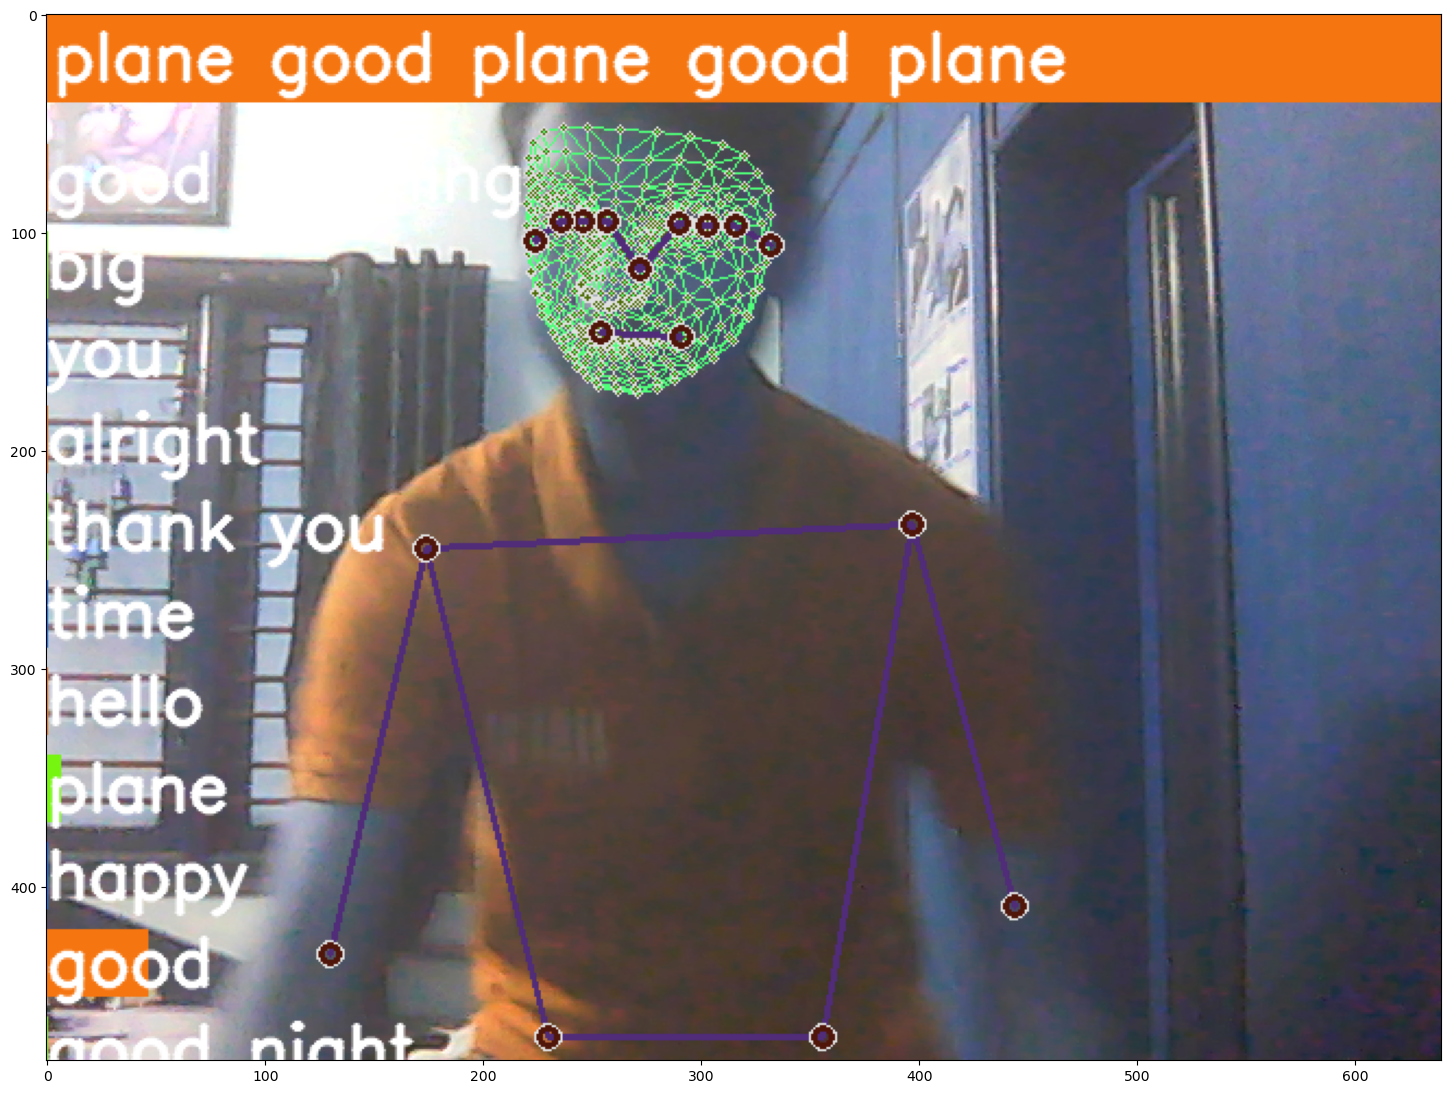

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
import gradio as gr

In [ ]:
def chalJaBhai():
  # 1. New detection variables
  sequence = []
  sentence = []
  predictions = []
  threshold = 0.5

  cap = cv2.VideoCapture(0)
  # Set mediapipe model
  with mp_holistic.Holistic(min_detection_confidence=0.9, min_tracking_confidence=0.9) as holistic:
      while cap.isOpened():

          # Read feed
          ret, frame = cap.read()
          frame = cv2.flip(frame, 1)
          # Make detections
          image, results = mediapipe_detection(frame, holistic)
          print(results)

          # Draw landmarks
          draw_styled_landmarks(image, results)

          # 2. Prediction logic
          keypoints = extract_keypoints(results)
          sequence.append(keypoints)
          sequence = sequence[-40:]

          if len(sequence) == 40:
              res = model.predict(np.expand_dims(sequence, axis=0))[0]
              print(actions[np.argmax(res)])
              predictions.append(np.argmax(res))


          #3. Viz logic
              if np.unique(predictions[-10:])[0]==np.argmax(res):
                  if res[np.argmax(res)] > threshold:

                      if len(sentence) > 0:
                          if actions[np.argmax(res)] != sentence[-1]:
                              sentence.append(actions[np.argmax(res)])
                      else:
                          sentence.append(actions[np.argmax(res)])

              if len(sentence) > 5:
                  sentence = sentence[-5:]

              # Viz probabilities
              image = prob_viz(res, actions, image, colors)

          cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
          cv2.putText(image, ' '.join(sentence), (3,30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

          # Show to screen
          cv2.imshow('OpenCV Feed', image)

          # Break gracefully
          if cv2.waitKey(10) & 0xFF == ord('q'):
              break
      cap.release()
      cv2.destroyAllWindows()

Extra


In [ ]:
# Obtain the true labels
true_labels = y_test

# Obtain the predicted labels
predicted_labels = yhat

print(true_labels)


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


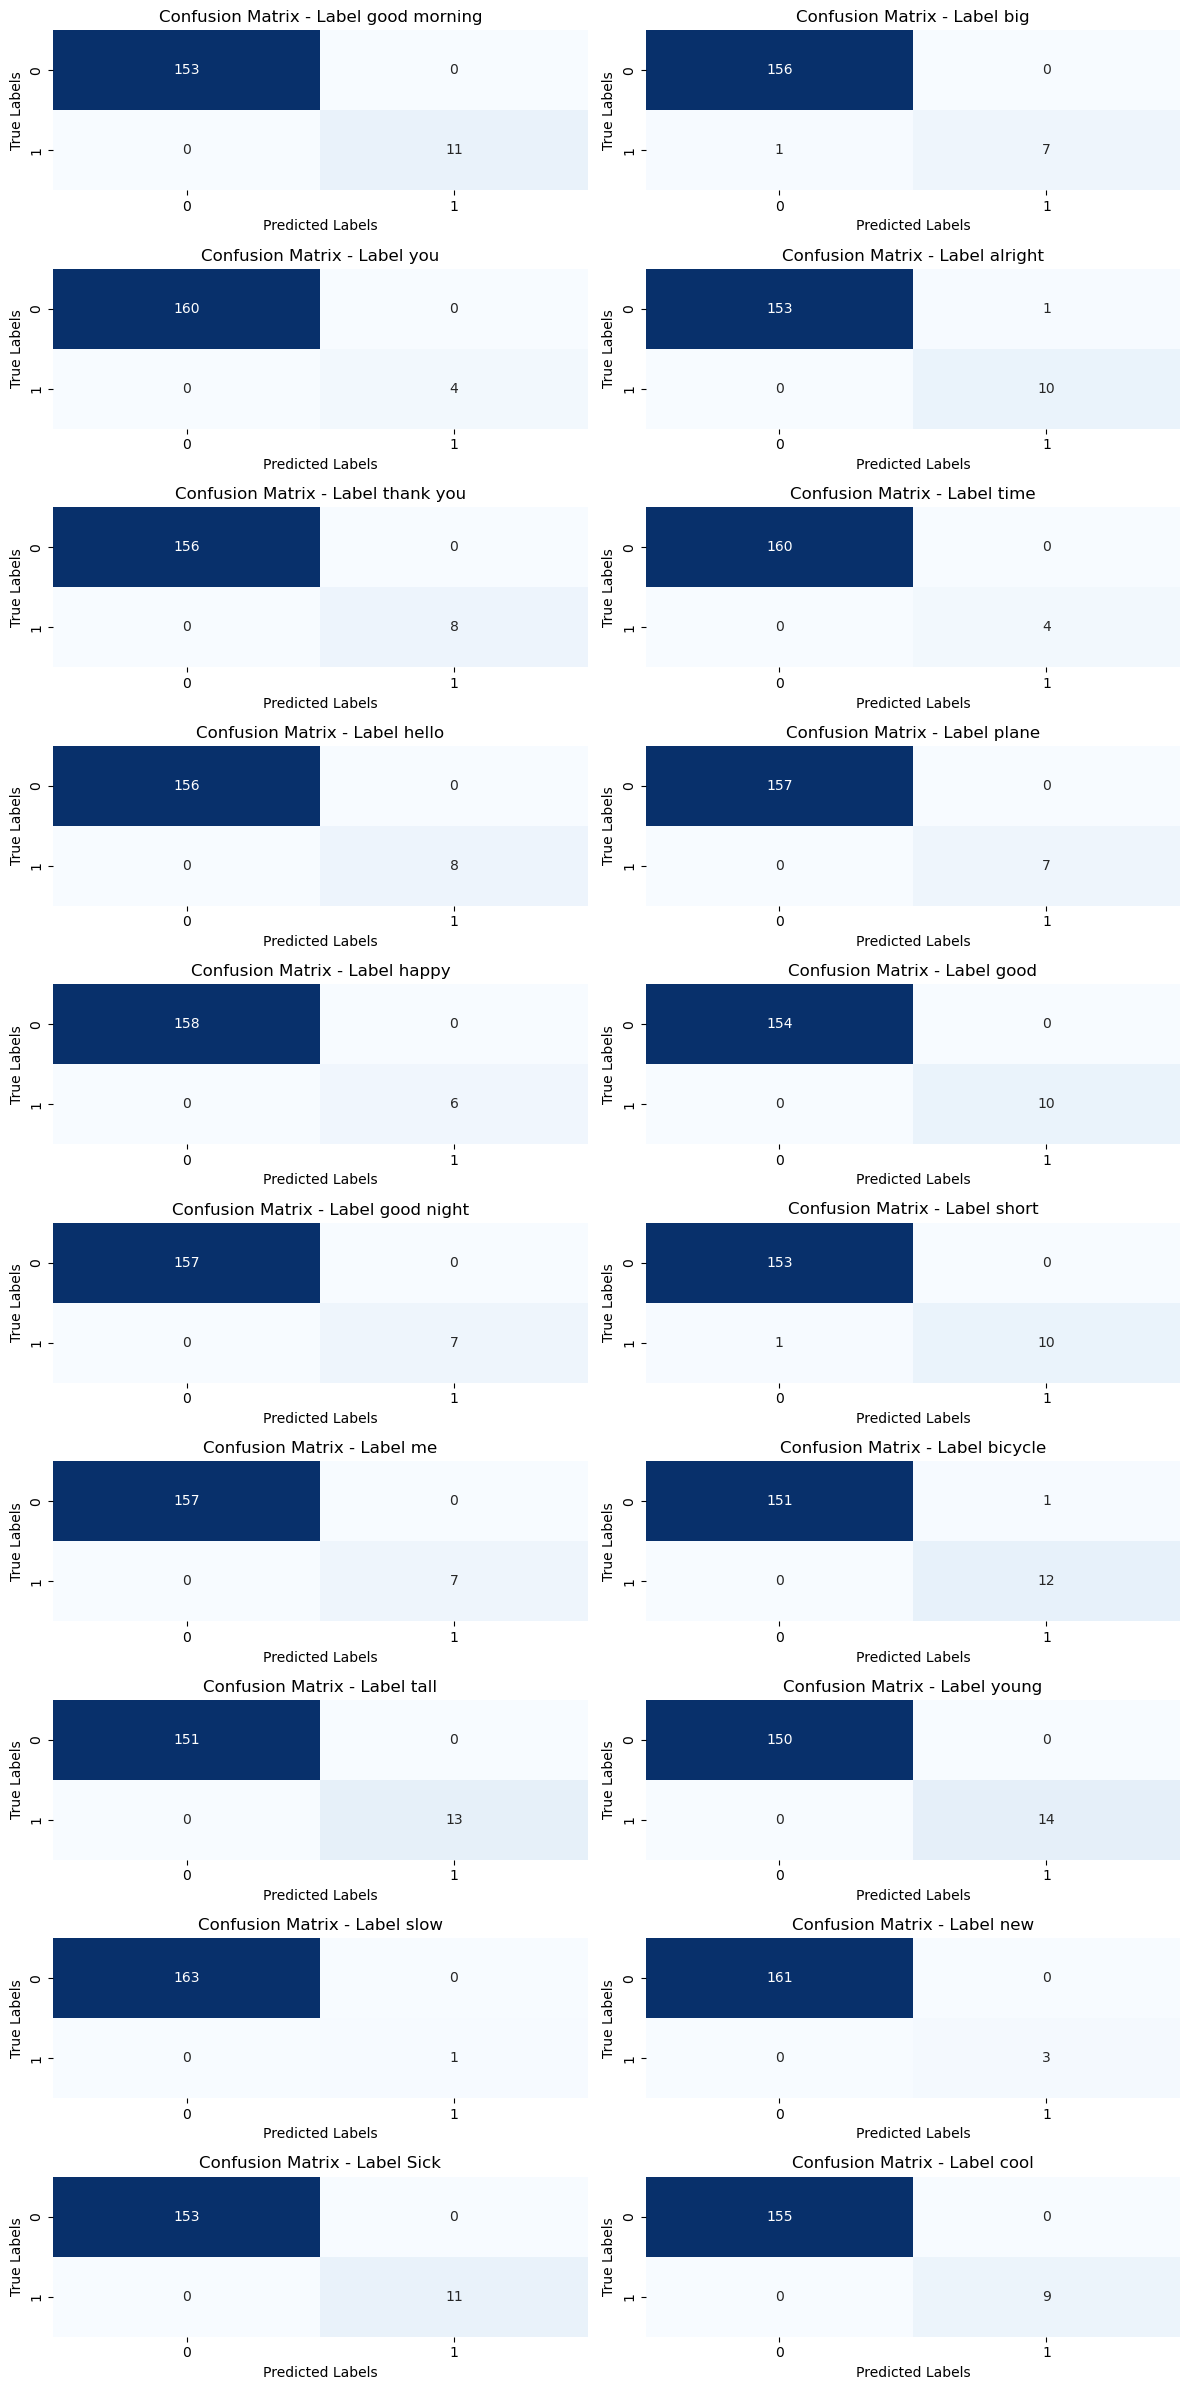

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the variables `cf_matrix` and `target_names`

target_names = targetClass

# Calculate the number of rows and columns for the subplots
num_labels = len(cf_matrix)
num_rows = (num_labels + 1) // 2  # Add 1 to handle odd number of labels
num_cols = 2

# Create a figure with subplots
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 24))

# Flatten the axs array to easily iterate over the subplots
axs = axs.flatten()

# Iterate over the labels and corresponding confusion matrices
for i, (label, matrix) in enumerate(zip(target_names, cf_matrix)):
    # Plot the confusion matrix
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[i])
    axs[i].set_title(f'Confusion Matrix - Label {label}')
    axs[i].set_xlabel('Predicted Labels')
    axs[i].set_ylabel('True Labels')

# Hide any empty subplots
for j in range(len(target_names), num_rows * num_cols):
    axs[j].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


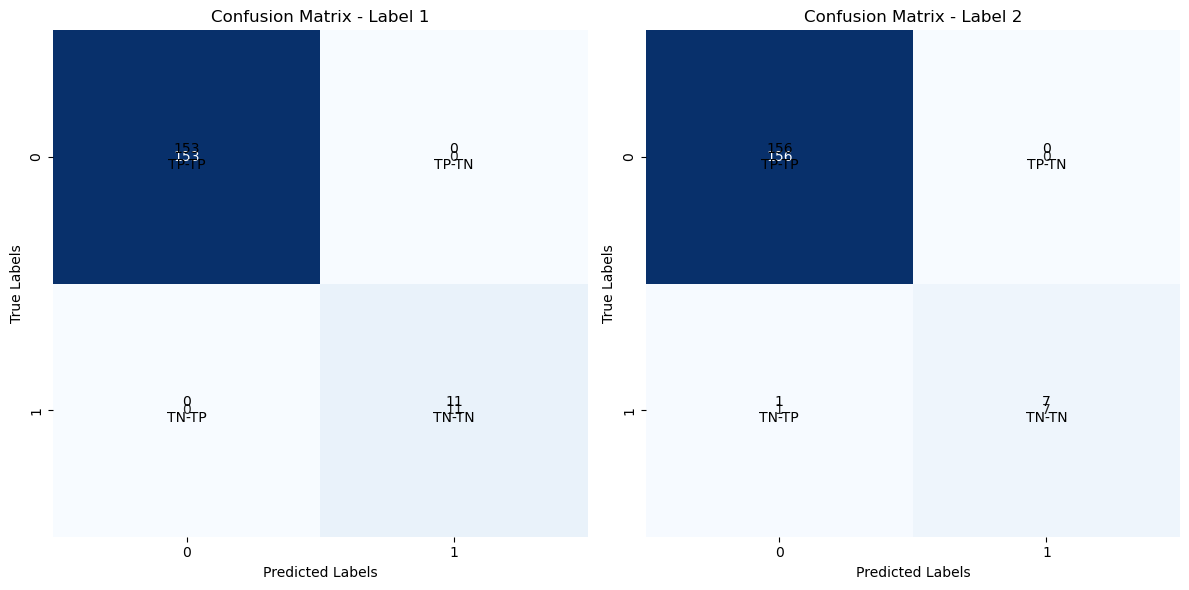

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have the variables `cf_matrix` and `target_names`

# Create a figure with subplots
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

# Plot the multilabel confusion matrix with labels
sns.heatmap(cf_matrix[0], annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0])
axs[0].set_title('Confusion Matrix - Label 1')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')

# Add labels for TP, TN, FP, FN
labels = ['TP', 'TN', 'FP', 'FN']
for i in range(cf_matrix[0].shape[0]):
    for j in range(cf_matrix[0].shape[1]):
        text = f"{cf_matrix[0][i][j]}\n{labels[i]}-{labels[j]}"
        axs[0].text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

sns.heatmap(cf_matrix[1], annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[1])
axs[1].set_title('Confusion Matrix - Label 2')
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')

# Add labels for TP, TN, FP, FN
labels = ['TP', 'TN', 'FP', 'FN']
for i in range(cf_matrix[1].shape[0]):
    for j in range(cf_matrix[1].shape[1]):
        text = f"{cf_matrix[1][i][j]}\n{labels[i]}-{labels[j]}"
        axs[1].text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

# Adjust the space between subplots
plt.tight_layout()

# Show the plot
plt.show()


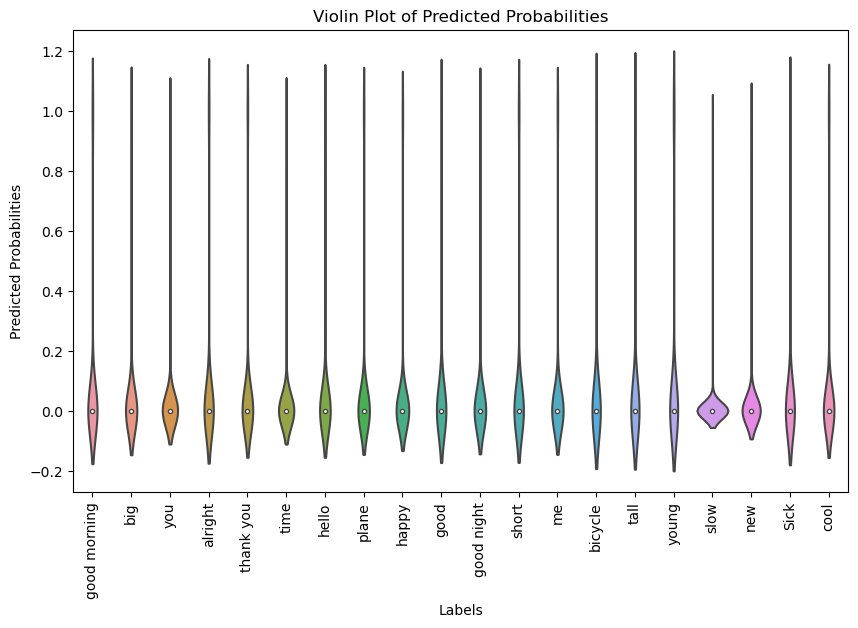

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have the predicted probabilities stored in a variable called `predicted_probs`
# `predicted_probs` should be a 2D array with shape (n_samples, n_labels)

# Convert the predicted probabilities to a DataFrame
df_probs = pd.DataFrame(predicted_probs, columns=target_names)

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_probs)
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.xlabel('Labels')
plt.ylabel('Predicted Probabilities')
plt.title('Violin Plot of Predicted Probabilities')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Assuming you have the true labels and predicted probabilities
true_labels = [0, 1, 0, 1, 0]  # True labels (0 or 1)
predicted_probs = [0.2, 0.6, 0.3, 0.8, 0.4]  # Predicted probabilities for positive class

# Calculate the precision and recall values at different probability thresholds
precision, recall, thresholds = precision_recall_curve(true_labels, predicted_probs)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()


GRADIO

In [ ]:
import gradio as gr
import cv2
import numpy as np
import mediapipe as mp

# model.save()
# Load model
from tensorflow.keras.models import load_model

# Load the model
model = load_model(r"E:\Downloads\Datasets\DATASET1\DATASET\models\D2M1.h5")

# Now you can use the loaded model for real-time testing
# Real time testing
from scipy import stats

colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num%3], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    return output_frame
# Setup for test:

import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
# !pip install moviepy
from moviepy.editor import VideoFileClip

# cap.release()


mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             )
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

import os
import numpy as np

# Path for exported data, numpy arrays
DATA_PATH = os.path.join('E:\\Downloads\\Datasets\\DATASET1\\DATASET\\')
print(DATA_PATH)

# DATA_PATH1 = os.path.join('E:\\Downloads\\Datasets\\DATASET1\\test\\')
# print(DATA_PATH1)


# Actions that we try to detect
actions = np.array(['good morning',
 'big',
 'you',
 'alright',
 'thank you',
 'time',
 'hello',
 'plane',
 'happy',
 'good',
 'good night',
 'short',
 'me',
 'bicycle',
 'tall',
'young',
'slow',
'new',
'Sick',
'cool'])

# print(actions)

# actions = np.array(['young', 'slow', 'new', 'Sick', 'cool'])

# Thirty videos worth of data
no_sequences = 20

# Videos are going to be 40 frames in length
sequence_length = 40

# Folder start
start_folder = 0

# preprocess and create labels and features

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

label_map = {label: num for num, label in enumerate(actions)}
label_map

def perform_realtime_detection(video):
    # return type(video)
    sequence = []
    sentence = []
    predictions = []
    threshold = 0.5

    cap = cv2.VideoCapture(video)
    with mp_holistic.Holistic(min_detection_confidence=0.9, min_tracking_confidence=0.9) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            frame = cv2.flip(frame, 1)
            image, results = mediapipe_detection(frame, holistic)

            draw_styled_landmarks(image, results)

            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-40:]

            if len(sequence) == 40:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                predictions.append(np.argmax(res))

                if np.unique(predictions[-10:])[0] == np.argmax(res):
                    if res[np.argmax(res)] > threshold:
                        if len(sentence) > 0:
                            if actions[np.argmax(res)] != sentence[-1]:
                                sentence.append(actions[np.argmax(res)])
                        else:
                            sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5:
                    sentence = sentence[-5:]

                image = prob_viz(res, actions, image, colors)

            cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            frame_with_overlays = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            return actions[np.argmax(res)]


            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()
    return actions[np.argmax(res)]

# Define the input component to capture webcam feed
input_component = gr.inputs.Video(source="webcam")

# Define the output component to display the predicted class
output_component = gr.outputs.Textbox(label="Predicted Class")

# Create the Gradio interface
interface = gr.Interface(
    fn=perform_realtime_detection,
    inputs=gr.components.Video(),
    outputs="text",
    capture_session=True
)



try:
    # Launch the Gradio interface
    interface.launch()
except Exception as e:
    print("An error occurred:", e)


E:\Downloads\Datasets\DATASET1\DATASET\
Running on local URL:  http://127.0.0.1:7882

To create a public link, set `share=True` in `launch()`.


In [ ]:
import gradio as gd

def funcfunc(text):
  return ", This is " + text

def hello(text):
  return "hello" + funcfunc(text)

interface = gd.interface.Interface(fn=hello, inputs="text", outputs="text").launch()

Running on local URL:  http://127.0.0.1:7879

To create a public link, set `share=True` in `launch()`.
